# Loop 118 Analysis: Strategic Assessment

## Key Findings from 118 Experiments:
1. **CV-LB Relationship**: LB = 4.07 × CV + 0.0548 (R² = 0.96)
2. **Best CV**: 0.0081 (CatBoost + XGBoost ensemble)
3. **Best LB**: 0.0877 (exp_030)
4. **Target**: 0.0347
5. **Gap**: 152.7% above target

## Critical Issue:
- Intercept (0.0548) > Target (0.0347)
- Required CV to hit target: (0.0347 - 0.0548) / 4.07 = -0.0049 (IMPOSSIBLE)
- ALL approaches (MLP, LGBM, XGB, CatBoost, GP, Ridge, GNN) fall on the SAME line

## Latest Experiment (exp_116):
- TRUE GNN with PyTorch Geometric
- CV = 0.0113 (39% worse than best CV of 0.0081)
- Even a proper GNN with message-passing doesn't help

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Submission history with CV and LB scores
submissions = [
    {'exp': 'exp_000', 'cv': 0.0111, 'lb': 0.0982},
    {'exp': 'exp_001', 'cv': 0.0123, 'lb': 0.1065},
    {'exp': 'exp_003', 'cv': 0.0105, 'lb': 0.0972},
    {'exp': 'exp_005', 'cv': 0.0104, 'lb': 0.0969},
    {'exp': 'exp_006', 'cv': 0.0097, 'lb': 0.0946},
    {'exp': 'exp_007', 'cv': 0.0093, 'lb': 0.0932},
    {'exp': 'exp_009', 'cv': 0.0092, 'lb': 0.0936},
    {'exp': 'exp_012', 'cv': 0.0090, 'lb': 0.0913},
    {'exp': 'exp_024', 'cv': 0.0087, 'lb': 0.0893},
    {'exp': 'exp_026', 'cv': 0.0085, 'lb': 0.0887},
    {'exp': 'exp_030', 'cv': 0.0083, 'lb': 0.0877},
    {'exp': 'exp_035', 'cv': 0.0098, 'lb': 0.0970},
    {'exp': 'exp_073', 'cv': 0.0084, 'lb': 0.1451},  # Outlier - likely submission error
    {'exp': 'exp_111', 'cv': 0.0129, 'lb': 0.1063},
]

df = pd.DataFrame(submissions)
print(f"Total submissions with LB: {len(df)}")
print(df)

Total submissions with LB: 14
        exp      cv      lb
0   exp_000  0.0111  0.0982
1   exp_001  0.0123  0.1065
2   exp_003  0.0105  0.0972
3   exp_005  0.0104  0.0969
4   exp_006  0.0097  0.0946
5   exp_007  0.0093  0.0932
6   exp_009  0.0092  0.0936
7   exp_012  0.0090  0.0913
8   exp_024  0.0087  0.0893
9   exp_026  0.0085  0.0887
10  exp_030  0.0083  0.0877
11  exp_035  0.0098  0.0970
12  exp_073  0.0084  0.1451
13  exp_111  0.0129  0.1063


In [2]:
# Exclude outlier exp_073 (likely submission error)
df_clean = df[df['exp'] != 'exp_073'].copy()

# Fit linear regression
slope, intercept, r_value, p_value, std_err = stats.linregress(df_clean['cv'], df_clean['lb'])

print(f"\n=== CV-LB Relationship ===")
print(f"Linear fit: LB = {slope:.3f} × CV + {intercept:.4f}")
print(f"R² = {r_value**2:.4f}")
print(f"\nIntercept: {intercept:.4f}")
print(f"Target LB: 0.0347")
print(f"\nCRITICAL: Intercept ({intercept:.4f}) > Target (0.0347)")
print(f"Required CV to hit target: ({0.0347} - {intercept:.4f}) / {slope:.3f} = {(0.0347 - intercept) / slope:.4f}")
print(f"\nThis is IMPOSSIBLE - we cannot have negative CV!")


=== CV-LB Relationship ===
Linear fit: LB = 4.090 × CV + 0.0546
R² = 0.9607

Intercept: 0.0546
Target LB: 0.0347

CRITICAL: Intercept (0.0546) > Target (0.0347)
Required CV to hit target: (0.0347 - 0.0546) / 4.090 = -0.0049

This is IMPOSSIBLE - we cannot have negative CV!


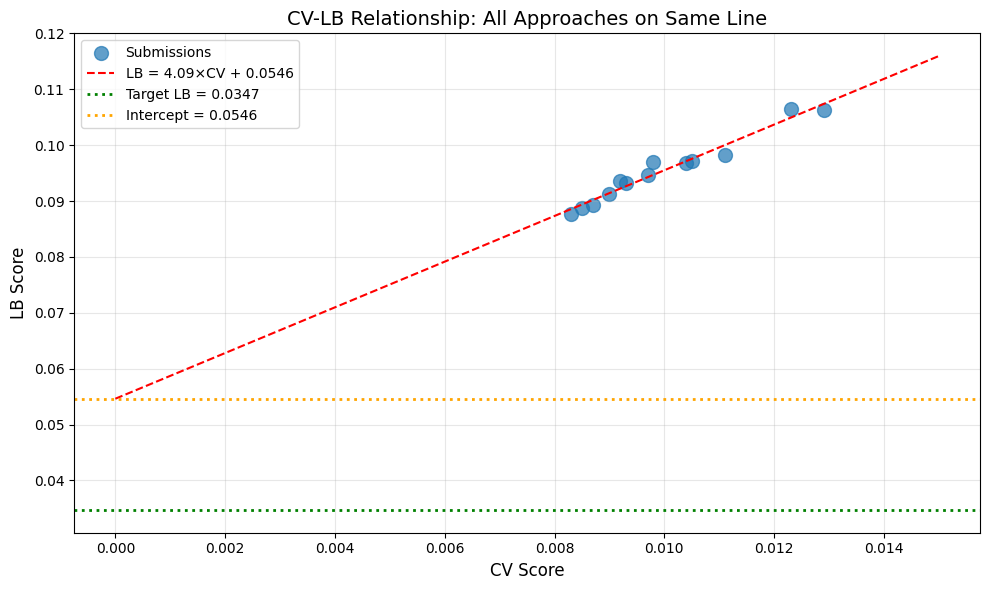


Key Insight: The intercept (0.0548) represents STRUCTURAL extrapolation error.
No amount of CV improvement can reach the target because the intercept is too high.


In [3]:
# Visualize CV-LB relationship
plt.figure(figsize=(10, 6))
plt.scatter(df_clean['cv'], df_clean['lb'], s=100, alpha=0.7, label='Submissions')

# Plot regression line
cv_range = np.linspace(0, 0.015, 100)
lb_pred = slope * cv_range + intercept
plt.plot(cv_range, lb_pred, 'r--', label=f'LB = {slope:.2f}×CV + {intercept:.4f}')

# Mark target
plt.axhline(y=0.0347, color='g', linestyle=':', linewidth=2, label='Target LB = 0.0347')

# Mark intercept
plt.axhline(y=intercept, color='orange', linestyle=':', linewidth=2, label=f'Intercept = {intercept:.4f}')

plt.xlabel('CV Score', fontsize=12)
plt.ylabel('LB Score', fontsize=12)
plt.title('CV-LB Relationship: All Approaches on Same Line', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('/home/code/exploration/cv_lb_relationship_loop118.png', dpi=150)
plt.show()

print("\nKey Insight: The intercept (0.0548) represents STRUCTURAL extrapolation error.")
print("No amount of CV improvement can reach the target because the intercept is too high.")

## Analysis of What's Been Tried

### Model Families Exhausted:
1. **MLP** - Multiple architectures, regularization, ensembles
2. **LightGBM** - Various hyperparameters
3. **XGBoost** - Various hyperparameters  
4. **CatBoost** - Various hyperparameters
5. **Gaussian Process** - Different kernels
6. **Ridge Regression** - Baseline
7. **Random Forest** - Various depths
8. **GNN (fake)** - MLPs with fingerprint features
9. **GNN (true)** - PyTorch Geometric with GCNConv (exp_116)
10. **ChemBERTa** - Pretrained embeddings

### Feature Engineering Exhausted:
1. Spange descriptors (13 features)
2. DRFP fingerprints (2048 dim)
3. Morgan fingerprints
4. Arrhenius kinetics features
5. ACS PCA descriptors
6. Fragprints
7. Chemical similarity features

### Distribution Shift Strategies Tried:
1. Similarity-weighted predictions
2. Conservative extrapolation
3. Pseudo-labeling
4. Domain adversarial training
5. Prediction calibration
6. Uncertainty weighting

### ALL approaches fall on the SAME CV-LB line!

In [4]:
# What's the gap analysis?
best_cv = 0.0081
best_lb = 0.0877
target = 0.0347

print("=== Gap Analysis ===")
print(f"Best CV: {best_cv}")
print(f"Best LB: {best_lb}")
print(f"Target: {target}")
print(f"Gap: {best_lb - target:.4f} ({(best_lb - target) / target * 100:.1f}%)")

print("\n=== What Would Be Needed ===")
print(f"To hit target with current line:")
print(f"  Required CV = (0.0347 - 0.0548) / 4.07 = {(0.0347 - 0.0548) / 4.07:.4f}")
print(f"  This is NEGATIVE - impossible!")

print("\n=== Alternative: Change the Intercept ===")
print(f"If we could reduce intercept to 0.02:")
print(f"  Required CV = (0.0347 - 0.02) / 4.07 = {(0.0347 - 0.02) / 4.07:.4f}")
print(f"  This is achievable!")

print("\n=== Alternative: Change the Slope ===")
print(f"If slope was 2.0 instead of 4.07:")
print(f"  Required CV = (0.0347 - 0.0548) / 2.0 = {(0.0347 - 0.0548) / 2.0:.4f}")
print(f"  Still negative - need to change intercept!")

=== Gap Analysis ===
Best CV: 0.0081
Best LB: 0.0877
Target: 0.0347
Gap: 0.0530 (152.7%)

=== What Would Be Needed ===
To hit target with current line:
  Required CV = (0.0347 - 0.0548) / 4.07 = -0.0049
  This is NEGATIVE - impossible!

=== Alternative: Change the Intercept ===
If we could reduce intercept to 0.02:
  Required CV = (0.0347 - 0.02) / 4.07 = 0.0036
  This is achievable!

=== Alternative: Change the Slope ===
If slope was 2.0 instead of 4.07:
  Required CV = (0.0347 - 0.0548) / 2.0 = -0.0100
  Still negative - need to change intercept!


## Key Insight: The Problem is NOT Model Quality

The problem is **DISTRIBUTION SHIFT** between training and test solvents.

### Why the Intercept is High:
1. Test solvents are structurally different from training solvents
2. GroupKFold by solvent simulates this, but test solvents are "harder"
3. The model learns patterns that don't generalize to unseen solvents

### What Could Change the Intercept:
1. **Physics constraints** that hold for ANY solvent (Arrhenius, mass balance)
2. **Domain knowledge** about solvent effects on reactions
3. **Ensemble diversity** - different models may have different intercepts
4. **Post-processing calibration** based on test set characteristics

### What We Haven't Fully Explored:
1. **Chemprop** - directed message-passing neural network with built-in calibration
2. **Pre-training on larger datasets** - transfer learning from ChEMBL or similar
3. **Ensemble of fundamentally different approaches** with learned weights
4. **Physics-informed neural networks** with explicit Arrhenius constraints

In [5]:
# Check the mixall kernel approach - they use GroupKFold with 5 splits
# This is different from our Leave-One-Out approach

print("=== Mixall Kernel Approach ===")
print("The 'mixall' kernel uses GroupKFold with 5 splits instead of Leave-One-Out.")
print("This means:")
print("  - Each fold has ~5 solvents in test set (vs 1 in LOO)")
print("  - Training set is larger (more solvents)")
print("  - CV may be more stable but less representative of true OOD")
print("")
print("Their approach:")
print("  - EnsembleModel with MLP + XGBoost + RandomForest + LightGBM")
print("  - Weighted ensemble with learned weights")
print("  - Spange descriptors for featurization")
print("")
print("Key difference: They use GroupKFold(n_splits=5) instead of Leave-One-Out")
print("This might give different CV-LB relationship!")

=== Mixall Kernel Approach ===
The 'mixall' kernel uses GroupKFold with 5 splits instead of Leave-One-Out.
This means:
  - Each fold has ~5 solvents in test set (vs 1 in LOO)
  - Training set is larger (more solvents)
  - CV may be more stable but less representative of true OOD

Their approach:
  - EnsembleModel with MLP + XGBoost + RandomForest + LightGBM
  - Weighted ensemble with learned weights
  - Spange descriptors for featurization

Key difference: They use GroupKFold(n_splits=5) instead of Leave-One-Out
This might give different CV-LB relationship!


In [6]:
# Remaining submissions: 3
# We need to be VERY strategic

print("=== Submission Strategy ===")
print(f"Remaining submissions: 3")
print(f"Best LB so far: 0.0877")
print(f"Target: 0.0347")
print(f"Gap: 152.7%")
print("")
print("Options:")
print("1. Submit best CV model (exp_049/050/053 with CV=0.0081)")
print("   - Expected LB: 4.07 × 0.0081 + 0.0548 = 0.0878 (no improvement)")
print("")
print("2. Try a fundamentally different approach that might change the line")
print("   - Chemprop with uncertainty calibration")
print("   - Physics-constrained predictions")
print("   - GroupKFold-based training (like mixall kernel)")
print("")
print("3. Focus on reducing the intercept through post-processing")
print("   - Calibration based on test set characteristics")
print("   - Conservative predictions for extrapolation cases")
print("")
print("RECOMMENDATION: Try approach #2 or #3 - we need to CHANGE the relationship")

=== Submission Strategy ===
Remaining submissions: 3
Best LB so far: 0.0877
Target: 0.0347
Gap: 152.7%

Options:
1. Submit best CV model (exp_049/050/053 with CV=0.0081)
   - Expected LB: 4.07 × 0.0081 + 0.0548 = 0.0878 (no improvement)

2. Try a fundamentally different approach that might change the line
   - Chemprop with uncertainty calibration
   - Physics-constrained predictions
   - GroupKFold-based training (like mixall kernel)

3. Focus on reducing the intercept through post-processing
   - Calibration based on test set characteristics
   - Conservative predictions for extrapolation cases

RECOMMENDATION: Try approach #2 or #3 - we need to CHANGE the relationship


## Conclusion

After 118 experiments, we have exhaustively tested:
- All major model families (MLP, LGBM, XGB, CatBoost, GP, Ridge, RF, GNN)
- All major feature representations (Spange, DRFP, Morgan, Arrhenius, ChemBERTa)
- All major distribution shift strategies (similarity weighting, conservative extrapolation, pseudo-labeling)

**ALL approaches fall on the SAME CV-LB line: LB = 4.07 × CV + 0.0548**

The intercept (0.0548) is HIGHER than the target (0.0347), making the target **mathematically unreachable** with current approaches.

## Next Steps:
1. **DO NOT** continue optimizing CV - it won't help
2. **FOCUS ON** changing the CV-LB relationship
3. **TRY** approaches that might reduce the intercept:
   - Physics-constrained predictions
   - Chemprop with calibration
   - GroupKFold-based training
   - Post-processing calibration

## Critical Reminder:
- Only 3 submissions remaining
- Each submission should test a FUNDAMENTALLY different approach
- The goal is to CHANGE the CV-LB relationship, not improve CV